In [19]:
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import torch
import requests
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
import random

In [2]:
PICKLES_ADDRESS = '../data/pickles/'
LAG_DATA_ADDRESS = 'lag_data/'
PUBMED_ADDRESS = '../data/pubmed_dataset/'
SBIR_ADDRESS = '../data/sbir_dataset/'

In [3]:
import psutil

def available_memory():
    available_ram = psutil.virtual_memory().available
    print(f"Available RAM: {available_ram / 1024 ** 3:.2f} GB")

def gpu_info():
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)
    print('GPUs available:', torch.cuda.device_count())
    print('current GPU number: ', torch.cuda.current_device())
    print('GPU name: ', torch.cuda.get_device_name(device))
    print('GPU capability: ', torch.cuda.get_device_capability(device))
    print('GPU memory: ', torch.cuda.get_device_properties(device).total_memory)
    print('GPU memory allocated: ', torch.cuda.memory_allocated(device))
    print('GPU memory cached: ', torch.cuda.memory_reserved(device))
    print('GPU memory reserved: ', torch.cuda.memory_reserved(device))
    print('GPU memory free: ', torch.cuda.memory_reserved(device) - torch.cuda.memory_allocated(device))


def ram_info():
    !free -h


available_memory()
gpu_info()  
ram_info()

Available RAM: 464.61 GB
GPUs available: 3
current GPU number:  0
GPU name:  NVIDIA RTX 6000 Ada Generation
GPU capability:  (8, 9)
GPU memory:  51010207744
GPU memory allocated:  0
GPU memory cached:  0
GPU memory reserved:  0
GPU memory free:  0
               total        used        free      shared  buff/cache   available
Mem:           503Gi        34Gi       233Gi       199Mi       235Gi       464Gi
Swap:          3.0Ti       3.0Mi       3.0Ti


In [4]:
# read data/pubmed_dataset/pubmed_embeddings_dict.pkl
with open(PUBMED_ADDRESS + 'pubmed_embeddings_dict.pkl', 'rb') as f:
    pubmed_embeddings_dict = pickle.load(f)
print('pubmed_embeddings_dict', len(pubmed_embeddings_dict))

pubmed_embeddings_dict 10928078


In [5]:
available_memory()

Available RAM: 417.40 GB


In [6]:
#read data/sbir_dataset/sbir_embeddings_dict.pkl
with open(SBIR_ADDRESS + 'sbir_embeddings_dict.pkl', 'rb') as f:
    sbir_embeddings_dict = pickle.load(f)
print('sbir_embeddings_dict', len(sbir_embeddings_dict))

sbir_embeddings_dict 63488


In [7]:
available_memory()

Available RAM: 417.19 GB


In [8]:
# embedding_vectors = random.sample(list(pubmed_embeddings_dict.values()), 1000000) + list(sbir_embeddings_dict.values())
embedding_vectors = list(pubmed_embeddings_dict.values()) + list(sbir_embeddings_dict.values())
len(embedding_vectors)

10991566

In [9]:
#import pca and train it on embedding_vectors
pca = PCA(n_components=3)
pca.fit(embedding_vectors)
pca

PCA(n_components=3)

In [10]:
#save pca
with open(PICKLES_ADDRESS + 'pca3d.pkl', 'wb') as f:
    pickle.dump(pca, f)

print('pca', pca)

pca PCA(n_components=3)


In [11]:
#transform pubmed embeddings and sbir embeddings with UMAP. make dictionaries named pmid2emb2d and sbir2emb2d
pmid2emb2d = {}
for pmid, emb in tqdm(pubmed_embeddings_dict.items()):
    pmid2emb2d[pmid] = pca.transform([emb])[0]

sbir2emb2d = {}
for sbir, emb in tqdm(sbir_embeddings_dict.items()):
    sbir2emb2d[sbir] = pca.transform([emb])[0]

#save pmid2emb2d and sbir2emb2d
with open(PICKLES_ADDRESS + 'pmid2emb3d.pkl', 'wb') as f:
    pickle.dump(pmid2emb2d, f)

with open(PICKLES_ADDRESS + 'sbid2emb3d.pkl', 'wb') as f:
    pickle.dump(sbir2emb2d, f)

print('pmid2emb3d', len(pmid2emb2d))
print('sbir2emb3d', len(sbir2emb2d))
print('done')

100%|██████████| 63488/63488 [00:02<00:00, 21413.76it/s]


pmid2emb3d 10928078
sbir2emb3d 63488
done


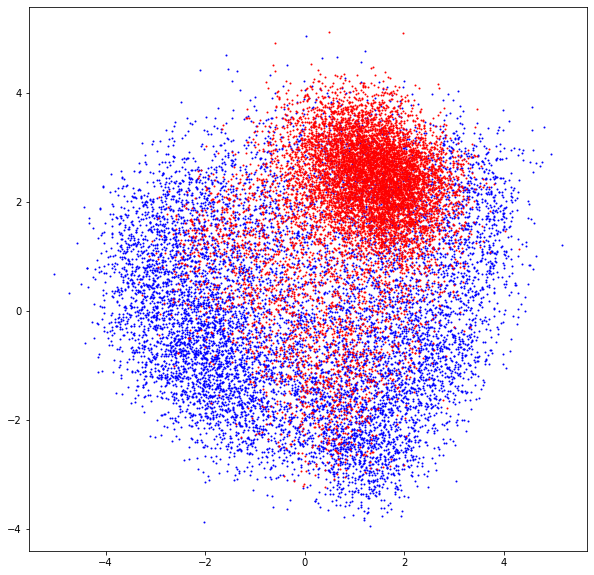

In [33]:
#show 10000 random pubmed embeddings and sbir embeddings. distinguish them with color
pmid2emb2d_sample = random.sample(list(pmid2emb2d.values()), 10000)
sbir2emb2d_sample = random.sample(list(sbir2emb2d.values()), 10000)

plt.figure(figsize=(10, 10))
plt.scatter([x[0] for x in pmid2emb2d_sample], [x[1] for x in pmid2emb2d_sample], s=1, c='b')
plt.scatter([x[0] for x in sbir2emb2d_sample], [x[1] for x in sbir2emb2d_sample], s=1, c='r')
plt.show()

In [20]:
#show 10000 random pubmed embeddings and sbir embeddings. distinguish them with color. use plotly 3d
pmid2emb3d_sample = random.sample(list(pmid2emb2d.values()), 10000)
sbir2emb3d_sample = random.sample(list(sbir2emb2d.values()), 10000)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=[point[0] for point in pmid2emb3d_sample],
    y=[point[1] for point in pmid2emb3d_sample],
    z=[point[2] for point in pmid2emb3d_sample],
    mode='markers',
    marker=dict(color='blue')
))

fig.add_trace(go.Scatter3d(
    x=[point[0] for point in sbir2emb3d_sample],
    y=[point[1] for point in sbir2emb3d_sample],
    z=[point[2] for point in sbir2emb3d_sample],
    mode='markers',
    marker=dict(color='red')
))

fig.update_layout(scene=dict(
    xaxis=dict(title='X'),
    yaxis=dict(title='Y'),
    zaxis=dict(title='Z')
))

fig.show()